In [1]:
import os
import pandas as pd
import numpy as np
from ops.imports_ipython import *
import ops.aggregate as agg 
import ops.annotate as anno

### Set directory parameters:

In [2]:
# Set screen directories
aggregate_function_home = "/lab/barcheese01/screens"
aggregate_function_dataset = "aconcagua"
home = os.path.join(aggregate_function_home, aggregate_function_dataset)

# Change working directory to home
os.chdir(home)

# Make directories
os.makedirs("aggregate_4/hdf", exist_ok=True)
os.makedirs("aggregate_4/tif", exist_ok=True)

##### load a subset of the data

The following cell contains crucial variables that need to be set according to your specific experimental setup and data organization. Please review and modify these variables as needed before proceeding with the analysis.

- `population_feature`: The column name that identifies your perturbation groups (e.g., 'gene_symbol_0' for CRISPR screens, 'treatment' for drug screens)

Ensure these variables accurately reflect your experimental setup to guarantee correct data processing and analysis.

In [3]:
population_feature = 'gene_symbol_0'

In [4]:
# Load subset of data -- may take ~1 minute
raw_df = agg.load_hdf_subset('merge_3/hdf/merged_final.hdf', n_rows=50000, population_feature=population_feature)
raw_df.to_hdf('aggregate_4/hdf/final_merged_subset.hdf', key='data', mode='w')
pd.Series(raw_df.columns).to_csv('aggregate_4/column_names.csv', index=False)
print(f"Loaded {len(raw_df)} cells with {len(raw_df.columns)} features")

Reading first 50,000 rows from merge_3/hdf/merged_final.hdf
Unique populations: 4913
well
A2    9349
B2    8794
A3    8158
A1    8089
B1    7827
B3    7783
Name: count, dtype: int64


/tmp/ipykernel_3198338/628507742.py:3: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block0_values] [items->Index(['well', 'sgRNA_0', 'gene_symbol_0', 'mapped_single_gene'], dtype='object')]

  raw_df.to_hdf('aggregate_4/hdf/final_merged_subset.hdf', key='data', mode='w')


Loaded 50000 cells with 1683 features


##### remove unassigned cells

In [5]:
clean_df = agg.clean_cell_data(raw_df, population_feature, filter_single_gene=False)
del raw_df

Found 37291 cells with assigned perturbations


##### apply feature transformations

The following cell contains crucial variables that need to be set according to your specific experimental setup and data organization. Please review and modify these variables as needed before proceeding with the analysis.

- `transformations`: CSV file containing feature transformation specifications. Each row defines a feature pattern and its transformation (e.g., 'log(feature)', 'log(feature-1)'), and should have a feature and transformation column
- `channels`: List of channels to apply feature transformations to (used to expand feature patterns like 'cell_{channel}_haralick_5_0')

Ensure these variables accurately reflect your experimental setup to guarantee correct data processing and analysis.

In [6]:
transformations = pd.read_csv('aggregate_4/transformations.csv')
channels = ['dapi','tubulin','gh2ax','phalloidin']

In [7]:
transformed_df = agg.feature_transform(
    clean_df, 
    transformations, 
    channels
)
transformed_df

/lab/barcheese01/mdiberna/OpticalPooledScreens/venv_ops_new/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


well  tile  cell_0          i_0          j_0  site  cell_1          i_1  \
1       A1   149     605  1480.261176  1479.401569    52     272   111.262500   
3       B2   278     661  1480.886792  1479.774311    62    5283  1382.702128   
4       B2   933     746  1481.030366  1480.300524   235    5381  1370.878788   
5       B1  1214     603  1478.942463  1479.640514   314    2290   745.436242   
6       A1    54     636  1480.818442  1480.801260    13    5319  1384.176471   
...    ...   ...     ...          ...          ...   ...     ...          ...   
49994   A2   723     578  1597.948601  1505.763826   187    2188   780.494845   
49995   A3   955     491  1388.888116  1400.789507   246    1911   726.417476   
49996   B3   939     677  1359.285940  1477.914692   238    2839   709.775510   
49997   B2   236     778  1432.430923  1369.033644    75    3108   719.031250   
49998   B2   622     774  1523.096410  1367.220080   157    2926   745.357895   

               j_1  distance  ...  cell_number_neighbors_1  \
1      1375.250000  1.590704  ...                        4   
3       732.372340  0.238346  ...                        5   
4       724.181818  0.369455  ...                        2   
5       726.194631  0.457858  ...                        4   
6      1367.117647  1.441651  ...                        5   
...            ...       ...  ...                      ...   
49994  1365.309278  0.255721  ...                        3   
49995  1337.475728  0.449554  ...                        5   
49996  1358.285714  0.305816  ...                        3   
49997    76.010417  0.584091  ...                        4   
49998   703.884211  0.126855  ...                        6   

       cell_percent_touching_1 cell_first_neighbor_distance  \
1                     0.794788                    54.320514   
3                     0.909375                    54.728719   
4                     0.634328                    48.821684   
5                     0.836538                    41.479966   
6                     1.000000                    62.547511   
...                        ...                          ...   
49994                 0.453258                    62.377936   
49995                 0.566757                    55.858484   
49996                 0.512367                    52.270971   
49997                 0.686154                    62.427552   
49998                 1.000000                    60.607211   

      cell_second_neighbor_distance cell_angle_between_neighbors  \
1                         65.869221                   128.894449   
3                         66.860282                   118.029498   
4                         53.070289                   110.845837   
5                         65.788387                   154.653263   
6                         66.890849                   134.947436   
...                             ...                          ...   
49994                     88.416452                    42.069789   
49995                     86.638228                   124.100090   
49996                     65.032001                   117.446056   
49997                     63.678504                    79.130232   
49998                     61.474914                   158.270843   

       cytoplasm_number_neighbors_1  cytoplasm_percent_touching_1  \
1                               4.0                      0.525164   
3                               5.0                      0.591463   
4                               2.0                      0.412621   
5                               4.0                      0.497817   
6                               5.0                      0.558882   
...                             ...                           ...   
49994                           3.0                      0.294659   
49995                           5.0                      0.377495   
49996                           3.0                      0.347722   
49997                   

##### standardize features

The following cell contains crucial variables that need to be set according to your specific experimental setup and data organization. Please review and modify these variables as needed before proceeding with the analysis.

- `control_prefix`: Prefix identifying control populations
- `group_columns`: Columns defining experimental groups (e.g., ['well'] for per-well standardization)
- `index_columns`: Columns uniquely identifying cells (e.g., ['tile', 'cell_0'])
- `cat_columns`: Categorical columns to preserve
- `feature_start`: First column containing measured features


We provide a useful function for suggesting these parameters, `suggest_parameters`. Ensure these variables accurately reflect your experimental setup to guarantee correct data processing and analysis.

In [8]:
agg.suggest_parameters(clean_df, population_feature)


Suggested Parameters:
--------------------------------------------------

Potential control prefixes found:
  - 'BPNT1'
  - 'NTF4'
  - 'INTS6'
  - 'nontargeting'
  - 'NT5C3B'
  - 'MNT'
  - 'INTS7'
  - 'FNTA'
  - 'TENT4B'
  - 'INTS10'
  - 'KNTC1'
  - 'INTS8'
  - 'INTS5'
  - 'TNNT2'
  - 'ARNTL2'
  - 'CCNT1'
  - 'TNNT1'
  - 'ANTXRL'
  - 'INTS3'
  - 'ZWINT'
  - 'INTS13'
  - 'INTS12'
  - 'CNTNAP1'
  - 'FNTB'
  - 'NTF3'
  - 'PCNT'
  - 'TRNT1'
  - 'INTS14'
  - 'INTS9'
  - 'B3GNT3'
  - 'SPINT1'
  - 'NT5C'
  - 'CNTROB'
  - 'INTS1'
  - 'DNTTIP2'
  - 'B3GNT4'
  - 'B3GNT2'
  - 'INTS11'
  - 'RINT1'
  - 'INTS4'
  - 'INTS2'

First few feature columns detected:
  - 'nucleus_dapi_mean'
  - 'nucleus_tubulin_mean'
  - 'nucleus_gh2ax_mean'
  - 'nucleus_phalloidin_mean'
  - 'nucleus_dapi_std'

Metadata columns detected:
  - Categorical: well, sgRNA_0, gene_symbol_0, mapped_single_gene


In [9]:
control_prefix = 'nontargeting'
group_columns = ['well']
index_columns = ['tile', 'cell_0']
cat_columns = ['gene_symbol_0', 'sgRNA_0']
feature_start = 'nucleus_dapi_mean'

In [10]:
# Identify features to standardize (all columns after mapped_single_gene)
feature_start_idx = transformed_df.columns.get_loc(feature_start)
target_features = transformed_df.columns[feature_start_idx:].tolist()
# Standardize the data
standardized_df = agg.grouped_standardization(
    transformed_df,
    population_feature=population_feature,
    control_prefix=control_prefix,
    group_columns=group_columns,
    index_columns=index_columns,
    cat_columns=cat_columns,
    target_features=target_features,
    drop_features=False
)
standardized_df

well  tile  cell_0          i_0          j_0  site  cell_1          i_1  \
0       A1   149     605  1480.261176  1479.401569    52     272   111.262500   
1       B2   278     661  1480.886792  1479.774311    62    5283  1382.702128   
2       B2   933     746  1481.030366  1480.300524   235    5381  1370.878788   
3       B1  1214     603  1478.942463  1479.640514   314    2290   745.436242   
4       A1    54     636  1480.818442  1480.801260    13    5319  1384.176471   
...    ...   ...     ...          ...          ...   ...     ...          ...   
37286   A2   723     578  1597.948601  1505.763826   187    2188   780.494845   
37287   A3   955     491  1388.888116  1400.789507   246    1911   726.417476   
37288   B3   939     677  1359.285940  1477.914692   238    2839   709.775510   
37289   B2   236     778  1432.430923  1369.033644    75    3108   719.031250   
37290   B2   622     774  1523.096410  1367.220080   157    2926   745.357895   

               j_1  distance  ...  cell_number_neighbors_1  \
0      1375.250000  1.590704  ...                   0.0000   
1       732.372340  0.238346  ...                   0.6745   
2       724.181818  0.369455  ...                  -1.3490   
3       726.194631  0.457858  ...                   0.0000   
4      1367.117647  1.441651  ...                   0.6745   
...            ...       ...  ...                      ...   
37286  1365.309278  0.255721  ...                  -0.6745   
37287  1337.475728  0.449554  ...                   0.6745   
37288  1358.285714  0.305816  ...                  -0.6745   
37289    76.010417  0.584091  ...                   0.0000   
37290   703.884211  0.126855  ...                   1.3490   

       cell_percent_touching_1 cell_first_neighbor_distance  \
0                     0.326027                    -0.549055   
1                     0.577121                    -0.411808   
2                    -0.619553                    -1.127478   
3                     0.569007                    -2.075654   
4                     1.160196                     0.445567   
...                        ...                          ...   
37286                -1.913519                     0.826159   
37287                -0.962153                    -0.125043   
37288                -1.249369                    -0.617851   
37289                -0.394071                     0.520947   
37290                 0.971413                     0.300403   

      cell_second_neighbor_distance cell_angle_between_neighbors  \
0                         -0.274666                     0.070169   
1                         -0.006661                    -0.183054   
2                         -1.515315                    -0.328546   
3                         -0.087592                     0.565036   
4                         -0.171546                     0.197718   
...                             ...                          ...   
37286                      2.962513                    -2.082716   
37287                      2.012393                     0.031300   
37288                     -0.090949                     0.035099   
37289                     -0.354754                    -0.970887   
37290                     -0.595832                     0.631959   

       cytoplasm_number_neighbors_1  cytoplasm_percent_touching_1  \
0                            0.0000                      0.314122   
1                            0.6745                      0.528361   
2                           -1.3490                     -0.700246   
3                            0.0000                      0.341531   
4                            0.6745                      0.523300   
...                             ...                           ...   
37286                       -0.6745                     -1.774630   
37287                        0.6745                     -0.819426   
37288                       -0.6745                     -1.040086   
37289                   

##### add file names

The following cell contains crucial variables that need to be set according to your specific experimental setup and data organization. Please review and modify these variables as needed before proceeding with the analysis.

- `channel_dict`: Maps fluorescence channels to their corresponding image files
- `base_ph_file_path`: Points to the "input_ph_tif" folder in your home directory

Ensure these variables accurately reflect your experimental setup to guarantee correct data processing and analysis.

In [11]:
channel_dict = {
    'dapi-tubulin': 'Channel-DAPI_1x1-GFP_1x1.tif',
    'gh2ax': 'Channel-A594_1x1.tif',
    'phalloidin': 'Channel-AF750_1x1.tif',
}
base_ph_file_path = os.path.join(home, "input_ph_tif")

In [12]:
standardized_df = agg.add_filenames(standardized_df,base_ph_file_path=base_ph_file_path,multichannel_dict=channel_dict)
standardized_df

well  tile  cell_0          i_0          j_0  site  cell_1          i_1  \
0       A1   149     605  1480.261176  1479.401569    52     272   111.262500   
1       B2   278     661  1480.886792  1479.774311    62    5283  1382.702128   
2       B2   933     746  1481.030366  1480.300524   235    5381  1370.878788   
3       B1  1214     603  1478.942463  1479.640514   314    2290   745.436242   
4       A1    54     636  1480.818442  1480.801260    13    5319  1384.176471   
...    ...   ...     ...          ...          ...   ...     ...          ...   
37286   A2   723     578  1597.948601  1505.763826   187    2188   780.494845   
37287   A3   955     491  1388.888116  1400.789507   246    1911   726.417476   
37288   B3   939     677  1359.285940  1477.914692   238    2839   709.775510   
37289   B2   236     778  1432.430923  1369.033644    75    3108   719.031250   
37290   B2   622     774  1523.096410  1367.220080   157    2926   745.357895   

               j_1  distance  ...  cell_second_neighbor_distance  \
0      1375.250000  1.590704  ...                      -0.274666   
1       732.372340  0.238346  ...                      -0.006661   
2       724.181818  0.369455  ...                      -1.515315   
3       726.194631  0.457858  ...                      -0.087592   
4      1367.117647  1.441651  ...                      -0.171546   
...            ...       ...  ...                            ...   
37286  1365.309278  0.255721  ...                       2.962513   
37287  1337.475728  0.449554  ...                       2.012393   
37288  1358.285714  0.305816  ...                      -0.090949   
37289    76.010417  0.584091  ...                      -0.354754   
37290   703.884211  0.126855  ...                      -0.595832   

       cell_angle_between_neighbors cytoplasm_number_neighbors_1  \
0                          0.070169                       0.0000   
1                         -0.183054                       0.6745   
2                         -0.328546                      -1.3490   
3                          0.565036                       0.0000   
4                          0.197718                       0.6745   
...                             ...                          ...   
37286                     -2.082716                      -0.6745   
37287                      0.031300                       0.6745   
37288                      0.035099                      -0.6745   
37289                     -0.970887                       0.0000   
37290                      0.631959                       1.3490   

      cytoplasm_percent_touching_1 cytoplasm_first_neighbor_distance  \
0                         0.314122                          0.017805   
1                         0.528361                          0.199351   
2                        -0.700246                         -1.397729   
3                         0.341531                         -2.100265   
4                         0.523300                         -0.075572   
...                            ...                               ...   
37286                    -1.774630                          1.378850   
37287                    -0.819426                         -0.367996   
37288                    -1.040086                         -0.451023   
37289                    -0.454786                          0.573916   
37290                     1.081728                          0.285516   

       cytoplasm_second_neighbor_distance  cytoplasm_angle_between_neighbors  \
0                               -0.443183                           0.008602   
1                                0.019087                          -0.364616   
2                               -1.472700                          -0.430475   
3                               -0.537135                           0.131506   
4                                0.125663                          -0.633293   
...                                   ...             

##### split mitotic and interphase data

The following cell contains crucial variables that need to be set according to your specific experimental setup and data organization. Please review and modify these variables as needed before proceeding with the analysis.

- `mitotic_threshold_variable`: Column name used to identify mitotic cells (e.g., 'nucleus_dapi_int' for DAPI intensity)
- `mitotic_threshold`: Numerical threshold to separate mitotic from interphase cells (examine intensity histogram to determine appropriate value)

Ensure these variables accurately reflect your experimental setup to guarantee correct data processing and analysis. Trying different approaches, splitting the data by more than one variable may be best.

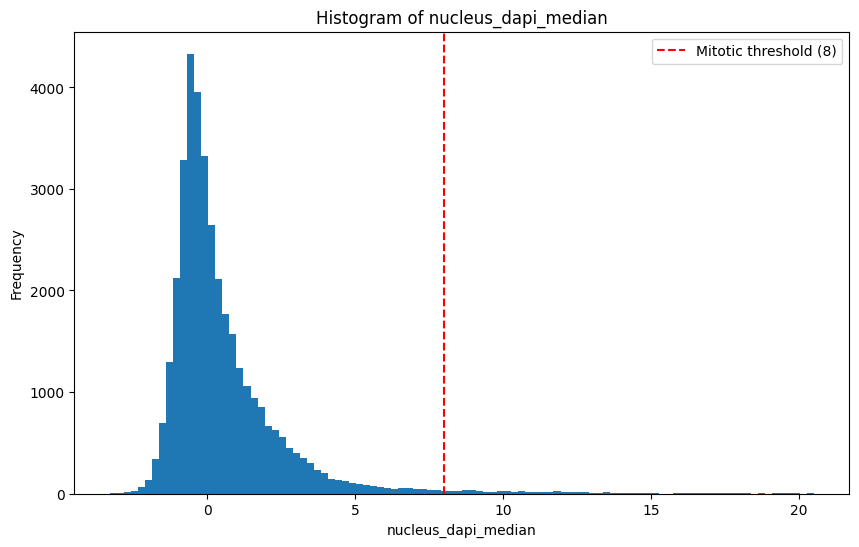

Number of mitotic cells: 535
Total cells: 37,291
Percent mitotic: 1.43%


In [13]:
mitotic_threshold_variable = 'nucleus_dapi_median'
mitotic_threshold = 8

percent_mitotic = agg.plot_mitotic_distribution_hist(
    standardized_df, 
    threshold_variable=mitotic_threshold_variable,
    threshold_value=mitotic_threshold
)

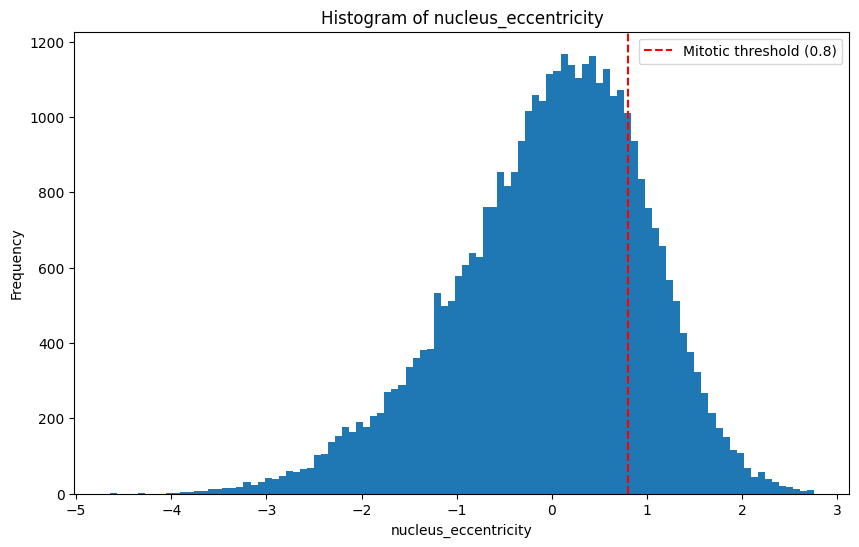

Number of mitotic cells: 7,823
Total cells: 37,291
Percent mitotic: 20.98%


In [14]:
mitotic_threshold_variable = 'nucleus_eccentricity'
mitotic_threshold = 0.8

percent_mitotic = agg.plot_mitotic_distribution_hist(
    standardized_df, 
    threshold_variable=mitotic_threshold_variable,
    threshold_value=mitotic_threshold
)

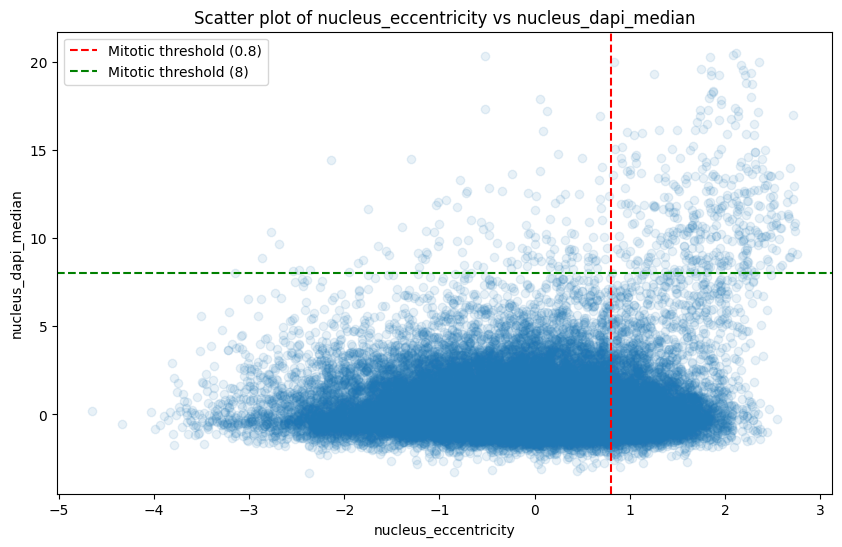

Number of mitotic cells: 402
Total cells: 37,291
Percent mitotic: 1.08%


In [15]:
threshold_variable_x = 'nucleus_eccentricity'
threshold_variable_y = 'nucleus_dapi_median'
threshold_value_x = 0.8
threshold_value_y = 8

agg.plot_mitotic_distribution_scatter(
    standardized_df,
    threshold_variable_x=threshold_variable_x,
    threshold_variable_y=threshold_variable_y,
    threshold_x=threshold_value_x,
    threshold_y=threshold_value_y,
    alpha=0.1
)

In [16]:
mitotic_threshold_variable = 'nucleus_dapi_median'
mitotic_threshold = 7

conditions = {
    mitotic_threshold_variable: (mitotic_threshold, 'greater'),
}
mitotic_df, interphase_df = agg.split_mitotic_simple(standardized_df, conditions)
print(f"Subsetting {len(mitotic_df)} mitotic cells and {len(interphase_df)} interphase cells")

Subsetting 694 mitotic cells and 36597 interphase cells


##### generate montages of mitotic and interphase cells

In [17]:
plotting_dict = {
    'dapi': {'filename': 'filename_dapi-tubulin', 'channel': 0},
    'tubulin': {'filename': 'filename_dapi-tubulin', 'channel': 1},
    'gh2ax': {'filename': 'filename_gh2ax'},
    'phalloidin': {'filename': 'filename_phalloidin'}
}

display_ranges = {
    'dapi': [(0, 14000)],
    'tubulin': [(0, 13000)],
    'gh2ax': [(0, 6000)],
    'phalloidin': [(350, 2000)]
}

# Default
agg.create_mitotic_cell_montage(
    df=mitotic_df,
    output_dir='aggregate_4/tif',
    output_prefix='mitotic',
    channels=plotting_dict,
    display_ranges=display_ranges
)

# Sorted by median dapi intensity
agg.create_mitotic_cell_montage(
    df=mitotic_df,
    output_dir='aggregate_4/tif',
    output_prefix='mitotic_sorted_nucleus_dapi_median',
    channels=plotting_dict,
    display_ranges=display_ranges,
    selection_params={
        'method': 'sorted',
        'sort_by': 'nucleus_dapi_median',
        'ascending': True
    }
)

Saved dapi montage to aggregate_4/tif/mitotic_dapi.tif
Saved tubulin montage to aggregate_4/tif/mitotic_tubulin.tif
Saved gh2ax montage to aggregate_4/tif/mitotic_gh2ax.tif
Saved phalloidin montage to aggregate_4/tif/mitotic_phalloidin.tif
Saved dapi montage to aggregate_4/tif/mitotic_sorted_nucleus_dapi_median_dapi.tif
Saved tubulin montage to aggregate_4/tif/mitotic_sorted_nucleus_dapi_median_tubulin.tif
Saved gh2ax montage to aggregate_4/tif/mitotic_sorted_nucleus_dapi_median_gh2ax.tif
Saved phalloidin montage to aggregate_4/tif/mitotic_sorted_nucleus_dapi_median_phalloidin.tif


##### re-standardize mitotic and interphase data

In [18]:
# Re-standardize mitotic population
mitotic_standardized_df = agg.grouped_standardization(
    mitotic_df,
    population_feature=population_feature,
    control_prefix=control_prefix,
    group_columns=group_columns,
    index_columns=index_columns,
    cat_columns=cat_columns,
    target_features=target_features,
    drop_features=True
)

# Re-standardize interphase population
interphase_standardized_df = agg.grouped_standardization(
    interphase_df,
    population_feature=population_feature,
    control_prefix=control_prefix,
    group_columns=group_columns,
    index_columns=index_columns,
    cat_columns=cat_columns,
    target_features=target_features,
    drop_features=True
)

##### collapse to guide rna

In [19]:
mitotic_sgrna_df = agg.collapse_to_sgrna(
    mitotic_standardized_df,
    method='median',
    target_features=target_features,
    index_features=[population_feature, 'sgRNA_0'],
    control_prefix=control_prefix
)

interphase_sgrna_df = agg.collapse_to_sgrna(
    interphase_standardized_df,
    method='median',
    target_features=target_features,
    index_features=[population_feature, 'sgRNA_0'],
    control_prefix=control_prefix
)


##### collapse to gene

In [20]:
mitotic_gene_df = agg.collapse_to_gene(
    mitotic_sgrna_df,
    target_features=target_features,
    index_features=[population_feature]
)

interphase_gene_df = agg.collapse_to_gene(
    interphase_sgrna_df,
    target_features=target_features,
    index_features=[population_feature]
)

##### return summary of dataset

In [21]:
summary = pd.DataFrame({
    'Stage': ['Raw Data', 'Mitotic Cells', 'Interphase Cells',
              'Mitotic sgRNAs', 'Interphase sgRNAs',
              'Mitotic Genes', 'Interphase Genes'],
    'Count': [len(clean_df), len(mitotic_df), len(interphase_df),
              len(mitotic_sgrna_df), len(interphase_sgrna_df),
              len(mitotic_gene_df), len(interphase_gene_df)]
})
print("\nAnalysis Summary of Data Subset:")
print(summary)


Analysis Summary of Data Subset:
               Stage  Count
0           Raw Data  37291
1      Mitotic Cells    694
2   Interphase Cells  36597
3     Mitotic sgRNAs    630
4  Interphase sgRNAs  12350
5      Mitotic Genes    582
6   Interphase Genes   4906
